[[2.00000000e+00 1.81000000e+00 1.64000000e+00 1.49000000e+00
  1.36000000e+00 1.25000000e+00 1.16000000e+00 1.09000000e+00
  1.04000000e+00 1.01000000e+00 1.00000000e+00 1.01000000e+00
  1.04000000e+00 1.09000000e+00 1.16000000e+00 1.25000000e+00
  1.36000000e+00 1.49000000e+00 1.64000000e+00 1.81000000e+00]
 [1.81000000e+00 1.62000000e+00 1.45000000e+00 1.30000000e+00
  1.17000000e+00 1.06000000e+00 9.70000000e-01 9.00000000e-01
  8.50000000e-01 8.20000000e-01 8.10000000e-01 8.20000000e-01
  8.50000000e-01 9.00000000e-01 9.70000000e-01 1.06000000e+00
  1.17000000e+00 1.30000000e+00 1.45000000e+00 1.62000000e+00]
 [1.64000000e+00 1.45000000e+00 1.28000000e+00 1.13000000e+00
  1.00000000e+00 8.90000000e-01 8.00000000e-01 7.30000000e-01
  6.80000000e-01 6.50000000e-01 6.40000000e-01 6.50000000e-01
  6.80000000e-01 7.30000000e-01 8.00000000e-01 8.90000000e-01
  1.00000000e+00 1.13000000e+00 1.28000000e+00 1.45000000e+00]
 [1.49000000e+00 1.30000000e+00 1.13000000e+00 9.80000000e-01
  8.5

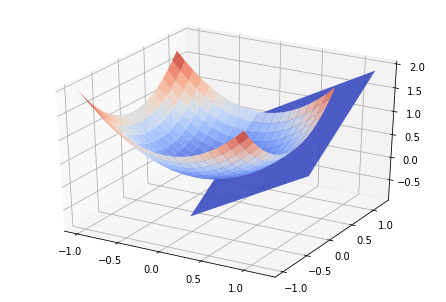

In [3]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def f(x):
    return x[0]**2 + x[1]**2

def gradient_f(x):
    return np.array([2*x[0], 2*x[1]])

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Plot cost surface
X = np.arange(-1, 1, 0.1)
Y = np.arange(-1, 1, 0.1)
X, Y = np.meshgrid(X, Y)
Z = f((X, Y))
print(Z)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, alpha=0.9)

# Plot x0
x0 = np.array([0.5, 0.5])
y0 = f(x0)
ax.plot([x0[0]], [x0[1]], [y0], 'ro')

# Plot gradient
dy0 = gradient_f(x0)
length = 0.2
dx = dy0*length/np.linalg.norm(dy0)
arrow_prop_dict = dict(mutation_scale=10, arrowstyle='-|>', color='g', shrinkA=0, shrinkB=0)
arrow1 = Arrow3D([x0[0], x0[0]+dx[0]], [x0[1], x0[1]+dx[1]], [y0, y0+np.dot(dy0, dx)], **arrow_prop_dict)
arrow_prop_dict = dict(mutation_scale=10, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0)
arrow2 = Arrow3D([x0[0], x0[0]-dx[0]], [x0[1], x0[1]-dx[1]], [y0, y0+np.dot(dy0, -dx)], **arrow_prop_dict)
ax.add_artist(arrow1)
ax.add_artist(arrow2)

# Plot equidistant points
n = 100
angle = np.linspace(0, 2*np.pi, n)
dx = np.concatenate((np.cos(angle).reshape(n, 1), np.sin(angle).reshape(n, 1)), axis=1)*length
xs = x0 + dx
y = np.array([y0 + np.dot(dy0, (x - x0)) for x in xs])
plt.plot(xs[:,0], xs[:,1], y)

# Plot tangent space
dX = np.array([-1, 1]) * 0.7
dY = np.array([-1, 1]) * 0.7
dX, dY = np.meshgrid(dX, dY)
y = np.array([y0 + np.dot(dy0, [dx, dy]) for dx, dy in zip(dX.flatten(), dY.flatten())]).reshape(2, 2)
ax.plot_surface(x0[0] + dX, x0[1] + dY, y, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, alpha=0.9)
plt.show()

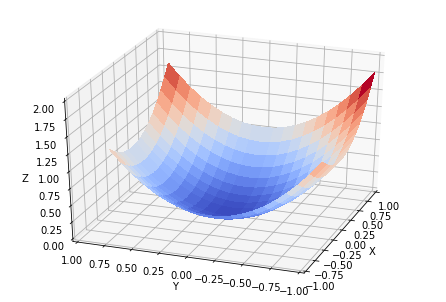

In [5]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

def cost_function(x):
    return x[0]**2 + x[1]**2

def gradient_cost_function(x):
    return np.array([2*x[0], 2*x[1]])

nb_steps = 20
x0 = np.array([0.8, 0.8])
learning_rate = 0.1

def gen_line():
    x = x0.copy()
    data = np.empty((3, nb_steps+1))
    data[:, 0] = np.concatenate((x, [cost_function(x)]))
    for t in range(1, nb_steps+1):
        grad = gradient_cost_function(x)
        x -= learning_rate * grad
        data[:, t] = np.concatenate((x, [cost_function(x)]))
    return data

def update_line(num, data, line):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])
    return line

# Attaching 3D axis to the figure
fig = plt.figure()
ax = p3.Axes3D(fig)

# Plot cost surface
X = np.arange(-0.5, 1, 0.1)
Y = np.arange(-1, 1, 0.1)
X, Y = np.meshgrid(X, Y)
Z = cost_function((X, Y))

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Optimize
data = gen_line()

# Creating line objects
# NOTE: Can't pass empty arrays into 3d version of plot()
line = ax.plot(data[0, 0:1], data[0, 0:1], data[0, 0:1], 'rx-', linewidth=2)[0]

# Setting the axes properties
ax.view_init(30, -160)

ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 2.0])
ax.set_zlabel('Z')

# Creating the Animation object
line_ani = animation.FuncAnimation(fig, update_line, nb_steps+1, fargs=(data, line), \
    interval=200, blit=False)

line_ani.save('gradient_descent.gif', dpi=80, writer='imagemagick')

plt.show()